In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.ensemble import VotingClassifier

In [4]:
df=pd.read_csv('/content/drive/MyDrive/sentiment_project/processed_reviews_100k.csv')

In [7]:
X_text = df['full_text']
X_extra = df[['verified_purchase', 'helpful_vote']]
y = df['sentiment']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
models = {
    'SVM_CHI2': joblib.load('/content/drive/MyDrive/sentiment_project/svm_model_pipeline_chi2_300.joblib'),
    'SVM_SVD': joblib.load('/content/drive/MyDrive/sentiment_project/svm_model_pipeline_svd.joblib'),
    'Logistic Regression_CHI2': joblib.load('/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_chi2_default.joblib'),
    'Logistic Regression_SVD': joblib.load('/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_svd.joblib'),
    'Naive Bayes CHI2': joblib.load('/content/drive/MyDrive/sentiment_project/nb_model_pipeline_chi2_default.joblib')
}
target_names = ['negative', 'neutral', 'positive']

<ipython-input-10-0ce1018fcb13>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_names, y=class_f1, palette="Set2")
<ipython-input-10-0ce1018fcb13>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_names, y=class_f1, palette="Set2")
<ipython-input-10-0ce1018fcb13>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_names, y=class_f1, palette="Set2")
<ipython-input-10-0ce1018fcb13>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `

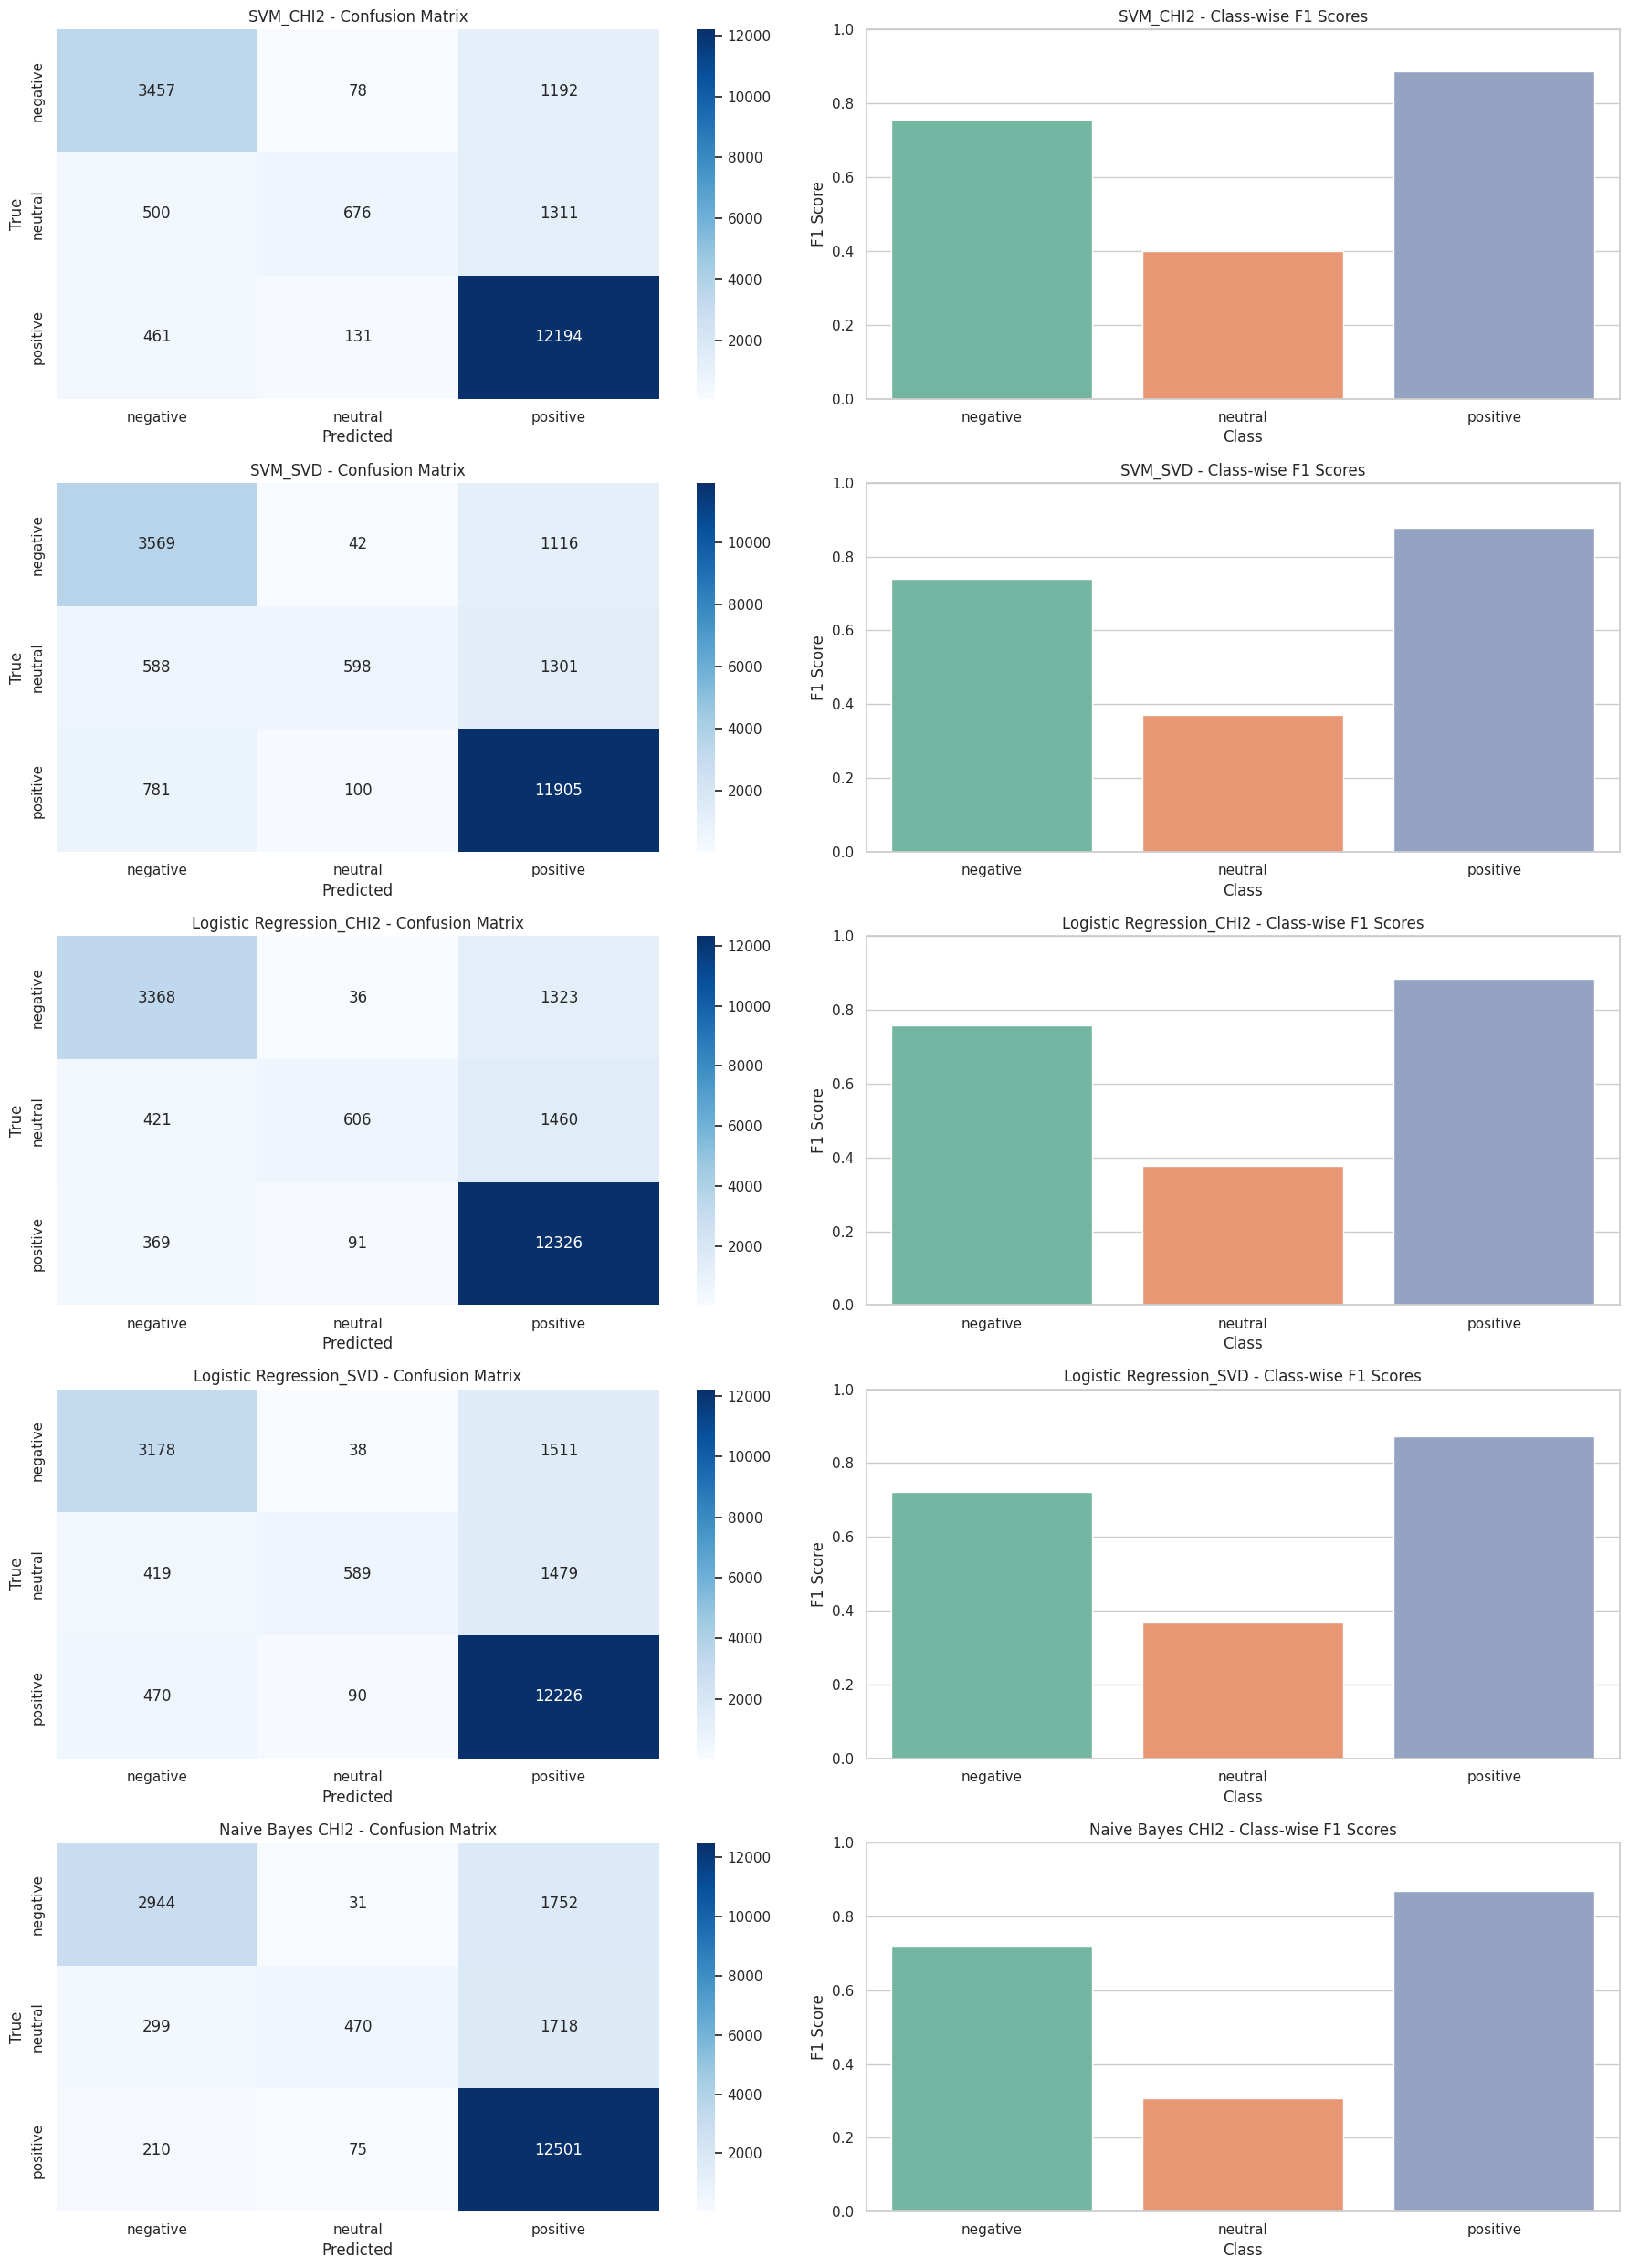


 Model Performance Summary:


,Model,Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,SVM_CHI2,0.81635,0.792005,0.652281,0.681458
1,SVM_SVD,0.80360,0.787370,0.642190,0.662501
2,Logistic Regression_CHI2,0.81500,0.817516,0.640064,0.672757
3,Logistic Regression_SVD,0.79965,0.802129,0.621781,0.654551
4,Naive Bayes CHI2,0.79575,0.817098,0.596499,0.632039


In [10]:
metrics_summary = []
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5 * len(models)))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    metrics_summary.append([name, acc, prec, rec, f1])

    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(len(models), 2, 2 * i - 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    class_f1 = [report[label]['f1-score'] for label in target_names]

    plt.subplot(len(models), 2, 2 * i)
    sns.barplot(x=target_names, y=class_f1, palette="Set2")
    plt.title(f"{name} - Class-wise F1 Scores")
    plt.ylim(0, 1)
    plt.ylabel("F1 Score")
    plt.xlabel("Class")

plt.tight_layout()
plt.show()
df_metrics = pd.DataFrame(metrics_summary, columns=["Model", "Accuracy", "Precision (macro)", "Recall (macro)", "F1 (macro)"])
print("\n Model Performance Summary:")
display(df_metrics)

SVM_CHI2 (best overall F1 and accuracy)

Logistic Regression_CHI2 (close second, different algorithm)

Naive Bayes CHI2 (lower scores, but adds diversity — ensemble might benefit)

In [12]:
svm_chi2 = joblib.load('/content/drive/MyDrive/sentiment_project/svm_model_pipeline_chi2_300.joblib')
logreg_chi2 = joblib.load('/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_chi2_default.joblib')
nb_chi2 = joblib.load('/content/drive/MyDrive/sentiment_project/nb_model_pipeline_chi2_default.joblib')

In [13]:
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_chi2),
        ('logreg', logreg_chi2),
        ('nb', nb_chi2)
    ],
    voting='hard'
)

In [17]:
small_X=X_train[:7000]
small_Y=y_train[:7000]

In [18]:
voting_clf.fit(small_X, small_Y)

VotingClassifier(estimators=[('svm',
                              GridSearchCV(cv=5,
                                           estimator=Pipeline(steps=[('tfidf',
                                                                      TfidfVectorizer(stop_words='english')),
                                                                     ('chi2',
                                                                      SelectKBest(k=300,
                                                                                  score_func=<function chi2 at 0x79decf52dbc0>)),
                                                                     ('clf',
                                                                      LinearSVC())]),
                                           n_jobs=-1,
                                           param_grid=[{'chi2__k': [200, 3000],
                                                        'clf': [LinearSVC(max_iter=3000)],
                                                        'clf__C': [1, 10],
                                                        'tfidf__max_features': [4000,
                                                                                5000],
                                                        'tf...
                                           estimator=Pipeline(steps=[('tfidf',
                                                                      TfidfVectorizer(stop_words='english')),
                                                                     ('chi2',
                                                                      SelectKBest(score_func=<function chi2 at 0x79decf52dbc0>)),
                                                                     ('clf',
                                                                      MultinomialNB())]),
                                           n_jobs=-1,
                                           param_grid={'chi2__k': [300, 500],
                                                       'clf__alpha': [0.1, 1.0,
                                                                      10.0],
                                                       'tfidf__max_features': [4000,
                                                                               5000],
                                                       'tfidf__ngram_range': [(1,
                                                                               1),
                                                                              (1,
                                                                               2)]},
                                           scoring=make_scorer(f1_score, response_method='predict', average=macro)))])

In [19]:
y_pred_ensemble = voting_clf.predict(X_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print("Ensemble Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred_ensemble, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=target_names))

Ensemble Model Evaluation:
Accuracy: 0.8195
F1 Score (macro): 0.6915

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.72      0.76      4727
     neutral       0.75      0.30      0.43      2487
    positive       0.83      0.96      0.89     12786

    accuracy                           0.82     20000
   macro avg       0.79      0.66      0.69     20000
weighted avg       0.81      0.82      0.80     20000



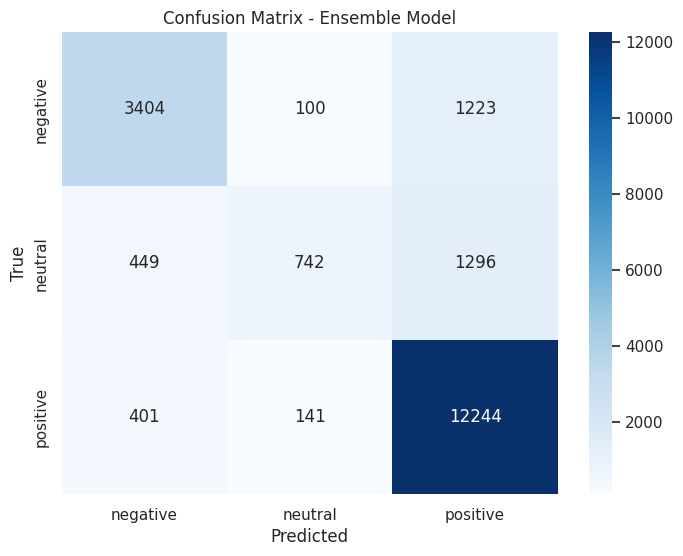

In [21]:
cm = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validated F1 Macro: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

In [24]:
from scipy.stats import mode
import numpy as np

models = {
    'SVM_CHI2': svm_chi2,
    'LogReg_CHI2': logreg_chi2,
    'NB_CHI2': nb_chi2
}
preds = []
for name, model in models.items():
    preds.append(model.predict(X_test))

preds = np.array(preds)
y_pred_ensemble = mode(preds, axis=0).mode[0]

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_ensemble, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ensemble))

TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.